In [8]:
import os

import numpy as np
from matplotlib import pyplot as plt
import h5py as h5

import specpy as sp

from pipeline2 import PipelineLevels, AcquisitionPipeline, DefaultNameHandler, HDF5RichData, HDF5DataStore
from pipeline2.taskgeneration import (AcquisitionTaskGenerator, JSONFileConfigLoader, DefaultFOVSettingsGenerator,
                                      DefaultScanOffsetsSettingsGenerator, DefaultLocationKeeper,
                                      DefaultLocationRemover, DefaultStageOffsetsSettingsGenerator,
                                      SpiralOffsetGenerator, NewestSettingsSelector, NewestDataSelector,
                                      BoundingBoxLocationGrouper, DefaultScanModeSettingsGenerator,
                                      DefaultScanFieldSettingsGenerator)
from pipeline2.detection import (LegacySpotPairFinder, SimpleSingleChannelSpotDetector, SimpleNucleusMidplaneDetector,
                                 SimpleLegacyFocusHold, SimpleLocationRepeater)
from pipeline2.imspector import ImspectorConnection, get_current_stage_coords
from pipeline2.stoppingcriteria import TimedStoppingCriterion

In [9]:
base_path = 'C:/Users//RESOLFT/Desktop/auto-sir/'
sample_name = 'a143_k562_tc3241_wt'

save_path = os.path.join(base_path, sample_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

SimpleLegacyFocusHold: No data for Z correction present -> skipping.
running acquisition:
stage offsets: [-0.00163878 -0.00484874  0.00186213]
scan offsets: [ 0.  0.  0.]
scan offsets global: [ 0.  0.  0.]
C:/Users//RESOLFT/Desktop/auto-sir-test//c769ed3402bce532aff6dc1a49ea8a9d_overview_0.msr
SimpleLegacyFocusHold: Corrected Focus (was 0.00186213, new 0.00186093)
Nucleus Detection:
old offset: [ 0.  0.  0.]
old len: [  5.01000000e-05   5.01000000e-05   1.00000000e-05]
old psz: [  3.00000000e-07   3.00000000e-07   4.00000000e-07]


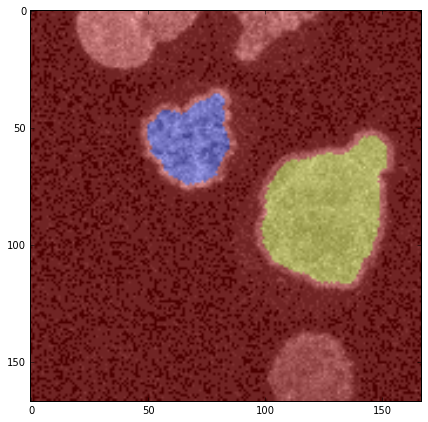

pixel result: (36, 50, 75, 85, 15.972179689603021)
pixel off: [ 67.5         55.5         15.97217969]
SimpleNucleusMidplaneDetector: Found Nucleus at [ -4.80000000e-06  -8.40000000e-06   1.38887188e-06], FOV: [1.4699999999999998e-05, 1.6379999999999999e-05, None]
pixel result: (54, 98, 117, 152, 15.61160105368141)
pixel off: [ 125.           85.5          15.61160105]
SimpleNucleusMidplaneDetector: Found Nucleus at [  1.24500000e-05   6.00000000e-07   1.24464042e-06], FOV: [2.268e-05, 2.6459999999999997e-05, None]
running acquisition:
stage offsets: [-0.00163878 -0.00484874  0.00186213]
scan offsets: [ -4.80000000e-06  -8.40000000e-06   1.38887188e-06]
scan offsets global: [ 0.  0.  0.]
C:/Users//RESOLFT/Desktop/auto-sir-test//c769ed3402bce532aff6dc1a49ea8a9d_overview_0_detail_0.msr
running acquisition:
stage offsets: [-0.00163878 -0.00484874  0.00186213]
scan offsets: [  1.24500000e-05   6.00000000e-07   1.24464042e-06]
scan offsets global: [ 0.  0.  0.]
C:/Users//RESOLFT/Desktop/aut

In [5]:
# plotting params
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]

# imspector object
im = sp.Imspector()

# init levels and name handler
pll = PipelineLevels('overview', 'detail')
name_handler = DefaultNameHandler(save_path, pll)

# abuse name_handler to get h5 filename
# calling with empty index gives just the random hash
h5file_name = name_handler.get_path([]).replace('.msr', '.h5')

# open resulting h5 file in context manager
with h5.File(h5file_name, mode='a') as h5fd:
    data_store = HDF5DataStore(h5fd, pll)

    # init pipeline
    pl = (AcquisitionPipeline('auto-sir-pipeline-1')
            .withImspectorConnection(ImspectorConnection(im).withVerbose())
            .withPipelineLevels(pll)
            .withNameHandler(name_handler)
            .withAddedStoppingCondition(TimedStoppingCriterion(2 * 60 * 60)))
    
    # attach h5 data store
    pl.withDataStorage(data_store)
        
    # overview task generator: same settings every time
    atg_overview = (AcquisitionTaskGenerator(pll.overview, 
                    DefaultLocationRemover(
                        JSONFileConfigLoader(['C:/Users/RESOLFT/Desktop/sir_overview_conf_water.json'])
                    ),
                    DefaultStageOffsetsSettingsGenerator(SpiralOffsetGenerator().withStart(get_current_stage_coords(im))),
                    DefaultScanModeSettingsGenerator(['xyz'], True),
                    DefaultFOVSettingsGenerator([[5e-5, 5e-5, 1e-5]], [[3e-7, 3e-7, 4e-7]]),
                    DefaultStageOffsetsSettingsGenerator(SimpleLegacyFocusHold(NewestDataSelector(pl, pll.overview)).withVerbose(True))
                )
                .withDelay(.4))

    # init detector in overview
    detector = (SimpleNucleusMidplaneDetector(NewestDataSelector(pl, pll.overview))
                .withVerbose()
                .withPlot()
                .withFilter({'area' : (500, 10000)})
                .withFOVExpansion(1.4)
               )

    # detail task generation: settings from last overview + new FOV + grouped detections
    # optionally repeat measurement to check reproducibility
    atg_detail = AcquisitionTaskGenerator(pll.detail,
                             DefaultLocationRemover(
                                 JSONFileConfigLoader(['C:/Users/RESOLFT/Desktop/sir_detail_sted+conf_water_50um_pinhole.json'])
                             ),
                             DefaultLocationKeeper(NewestSettingsSelector(pl, pll.overview)),
                             DefaultScanFieldSettingsGenerator(detector, [3e-8, 3e-8, None]))
    atg_detail.withDelay(.2)

    # overview callback: re-add overview
    pl.withCallbackAtLevel(atg_overview, pll.overview)
    # overview callback 2: detect & do detail
    pl.withCallbackAtLevel(atg_detail, pll.overview)

    # call overview atg once to add first measurement to pipeline
    atg_overview(pl)

    # GO
    pl.run()